In [1]:
import torch
from torch import nn, optim
import numpy as np
from matplotlib import pyplot as plt
import math
import random
import time
import pickle


import scipy
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import find_peaks, StateSpace, bode, lsim
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d


import deepSI
from deepSI import System_data, System_data_list
from deepSI.utils import simple_res_net, feed_forward_nn, integrator_RK4, integrator_euler
from deepSI.fit_systems import SS_encoder_deriv_general
from deepSI.fit_systems.encoders import SS_encoder_general_hf, default_encoder_net, hf_net_default
from deepSI.utils.torch_nets import time_integrators



In [2]:
# Variables and settings
nx = 4 #number of states for the system
nu = 1 #nummber of measured input
ny = 1 #nummber of measured output

# Define properties of the system
m1 = 1.  # mass 1
m2 = 1. # mass 2
k1 = 1.  # spring constant 1 (linear term)
k1_nl =0.1  # nonlinear spring constant for the cubic term
k2 = 1.  # spring constant 2
c1 = 0.5  # damping coefficient 1
c2 =0.5 # damping coefficient 2
noise_std = 0.001 #measurement noise std

# properties of the input signal
amplitude = 0.1 # multisine component amplitudes 
fs = 10 # sampling frequency (Hz)
N = 1000  # number of samples per period

t_s = 1/fs # sampling time (sec)
f_0 = fs/N # frequency resolution (Hz)
T_0 = 1/f_0 # period length (sec)

f_min = f_0 # min excited frequency in Hz
f_max = 1. # max excited frequency in Hz

k_min = math.ceil(f_min/f_0)  # freq bin corresponding to f_min
k_max = math.floor(f_max/f_0) # freq bin corresponding to f_max
num_freqs = k_max-k_min+1

print ('f_0=', f_0 )
print ('f_min=', f_min )
print ('f_max=', f_max )
print ('Ts=', t_s )
print ('T=', T_0 )
print ('N=', N )
print ('num_freqs=', num_freqs )

# SUBNET hyperparameters
nb = 20    # encoder past inputs
na = 20    # encoder past outputs
nf = 200  #T or futur steps in encoder



f_0= 0.01
f_min= 0.01
f_max= 1.0
Ts= 0.1
T= 100.0
N= 1000
num_freqs= 100


In [7]:
# Define properties of the system
m1 = 1.  # mass 1
m2 = 1. # mass 2
k1 = 1.  # spring constant 1 (linear term)
k1_nl =0.1  # nonlinear spring constant for the cubic term
k2 = 1.  # spring constant 2
c1 = 0.5  # damping coefficient 1
c2 =0.5 # damping coefficient 2
noise_std = 0.001 #measurement noise std

# Define the state-space ODE models
class My_sys2(deepSI.System_deriv):
    def __init__(self, noise_std, nx, dt, method='RK45'):
        super(My_sys2, self).__init__(nx=nx,dt=t_s)
        # Initialize the state with random values between 0 and 1
        self.x = np.random.rand(nx)
        self.noise_std = noise_std

    def deriv(self, x, u):
        q1, p1, q2, p2 = x

        dq1 = p1 / m1
        dq2 = p2 / m2
        
        # Derivatives for mass 1
        dp1 = -(k1+k2)*q1 -k1_nl*q1**3 - (c1+c2)*dq1 +k2*q2 +c2*dq2

        # Derivatives for mass 2
        dp2 = k2*q1 + c2*dq1 -k2*q2 -c2*dq2 +u

        return [dq1, dp1, dq2, dp2]

    def h(self, x, u, noise_std=None):
        # Use the instance's noise_std if none is provided
        if noise_std is None:
            noise_std = self.noise_std
        y = x + np.random.randn(*x.shape) * noise_std
        return y[3]  

sys2 = My_sys2(noise_std=noise_std, nx=nx, dt=t_s)


In [3]:
# Define the state-space ODE models
class My_sys2(deepSI.System_deriv):
    def __init__(self, noise_std, nx, dt, method='DOP853'):
        super(My_sys2, self).__init__(nx=nx, dt=dt)
        self.x = np.random.rand(nx)  # Initialize state
        self.noise_std = noise_std
        self.method = method  # Store the solver method

    def deriv(self, x, u):
        q1, p1, q2, p2 = x

        dq1 = p1 / m1
        dq2 = p2 / m2
        
        # Derivatives for mass 1
        dp1 = -(k1+k2)*q1 - k1_nl*q1**3 - (c1+c2)*dq1 + k2*q2 + c2*dq2

        # Derivatives for mass 2
        dp2 = k2*q1 + c2*dq1 - k2*q2 - c2*dq2 + u

        return [dq1, dp1, dq2, dp2]

    def h(self, x, u, noise_std=None):
        if noise_std is None:
            noise_std = self.noise_std
        y = x + np.random.randn(*x.shape) * noise_std
        #output is velocity of mass 2
        return y[3]  

    def simulate_experiment(self, system_data, x0=None):
        from scipy.integrate import solve_ivp
        # Use default state if none is provided
        if x0 is None:
            x0 = self.x
        t = np.arange(0, system_data.time_len() * self.dt, self.dt)
        def dynamics(t, x):
            u = system_data.interp_input(t)  # Interpolated input
            return self.deriv(x, u)
        # Solve the ODE with the preferred method
        sol = solve_ivp(dynamics, [t[0], t[-1]], x0, t_eval=t, method=self.method)
        x = sol.y.T  # Transpose to get time as rows
        # Generate output
        y = np.array([self.h(xi, system_data.interp_input(ti)) for xi, ti in zip(x, t)])
        return deepSI.System_data(u=system_data.u, y=y, dt=self.dt)
    

# Input force (multi-sine)
def multi_sine_with_random_phase_and_frequency_range(f_min, f_max, num_freqs, amplitude, t):
    frequencies = np.linspace(f_min, f_max, num_freqs) # for uniform distribution of f
    y = np.zeros_like(t)
    for i in range(len(frequencies)):
        phase = np.random.uniform(0, 2 * np.pi)
        y += amplitude * np.sin(2 * np.pi * frequencies[i] * t + phase)
    y_rms = np.sqrt(np.mean(y ** 2)) # Calculate RMS value
    scale_factor = amplitude / y_rms * 5
    y *= scale_factor 
    return y



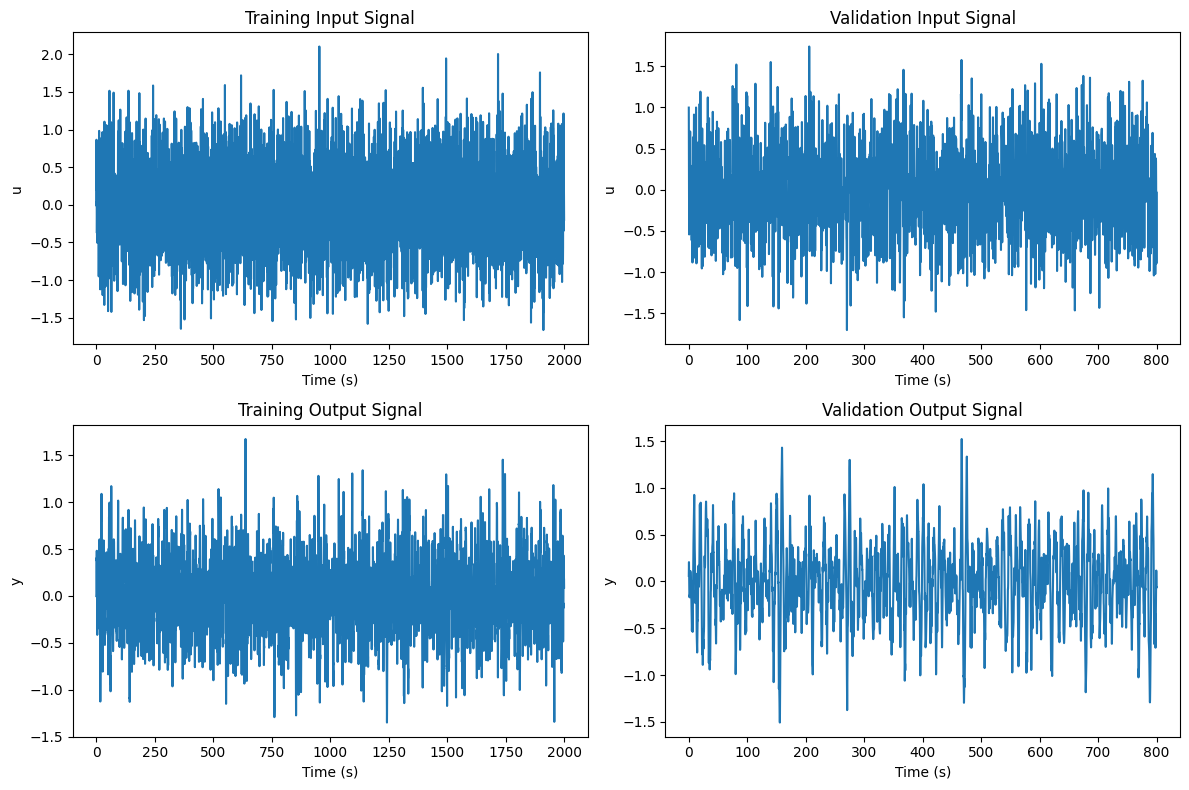

In [5]:
# Generate train and validation dataset with noise
random.seed(1) 
np.random.seed(1)

# Initial setting and time resolutions
num_segments_train, num_segments_val = 20, 8
t_segment = np.arange(0, T_0, t_s)
t_end_train, t_end_val = num_segments_train * T_0, num_segments_val * T_0
t_combined = np.arange(0, t_end_train + t_end_val, t_s)
sys2 = My_sys2(noise_std=noise_std, nx=nx, dt=t_s) 

# Generate combined input signal
u_combined = np.concatenate([
    multi_sine_with_random_phase_and_frequency_range(f_min, f_max, num_freqs, amplitude, t_segment)
    for _ in range(num_segments_train + num_segments_val)
])[:len(t_combined)]

# Apply experiment to generate output with noise
exp_combined = deepSI.System_data(u=u_combined, dt=t_s)
dataset_combined = sys2.apply_experiment(exp_combined)

# Split combined dataset into training and validation
train_len = int(t_end_train / t_s)
u_train, y_train = dataset_combined.u[:train_len], dataset_combined.y[:train_len]
u_val, y_val = dataset_combined.u[train_len:], dataset_combined.y[train_len:]

dataset_train = deepSI.System_data(u=u_train, y=y_train, dt=t_s)
dataset_val = deepSI.System_data(u=u_val, y=y_val, dt=t_s)

# Reshape inputs and outputs to match nu and ny
for dataset in [dataset_train, dataset_val]:
    dataset.u = dataset.u.reshape(-1, nu)
    dataset.y = dataset.y.reshape(-1, ny)

# Plot input and output signals
plt.figure(figsize=(12, 8))

for i, (data, label) in enumerate([(dataset_train, 'Training'), (dataset_val, 'Validation')], 1):
    plt.subplot(2, 2, i)
    plt.plot(np.arange(len(data.u)) * t_s, data.u)
    plt.title(f'{label} Input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('u')

    plt.subplot(2, 2, i + 2)
    plt.plot(np.arange(len(data.y)) * t_s, data.y)
    plt.title(f'{label} Output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('y')

plt.tight_layout()
plt.show()


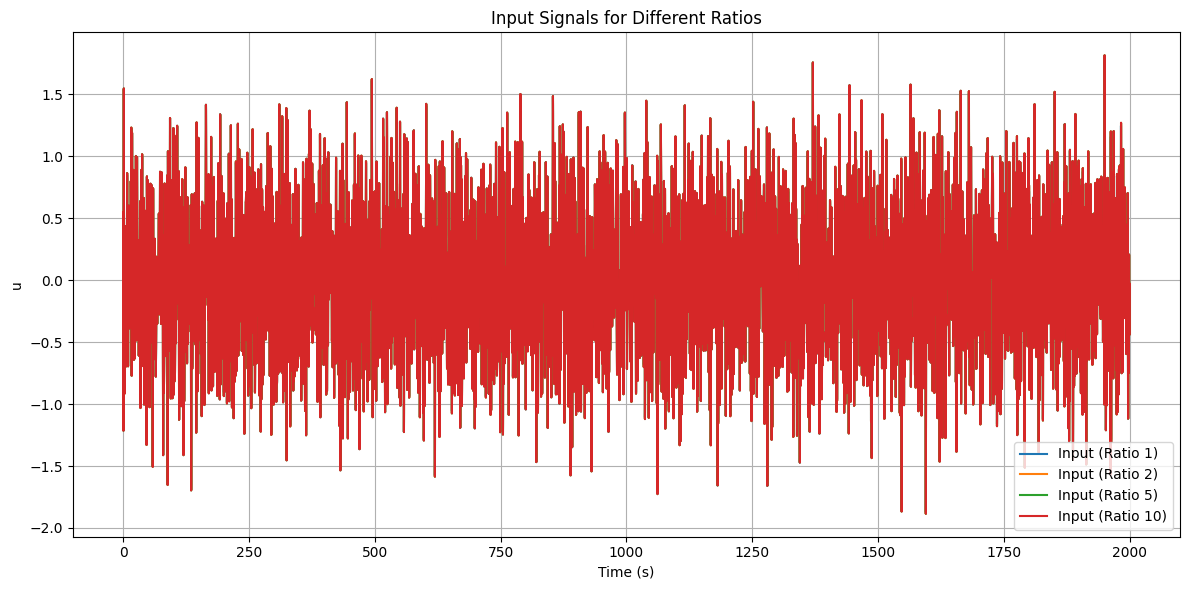

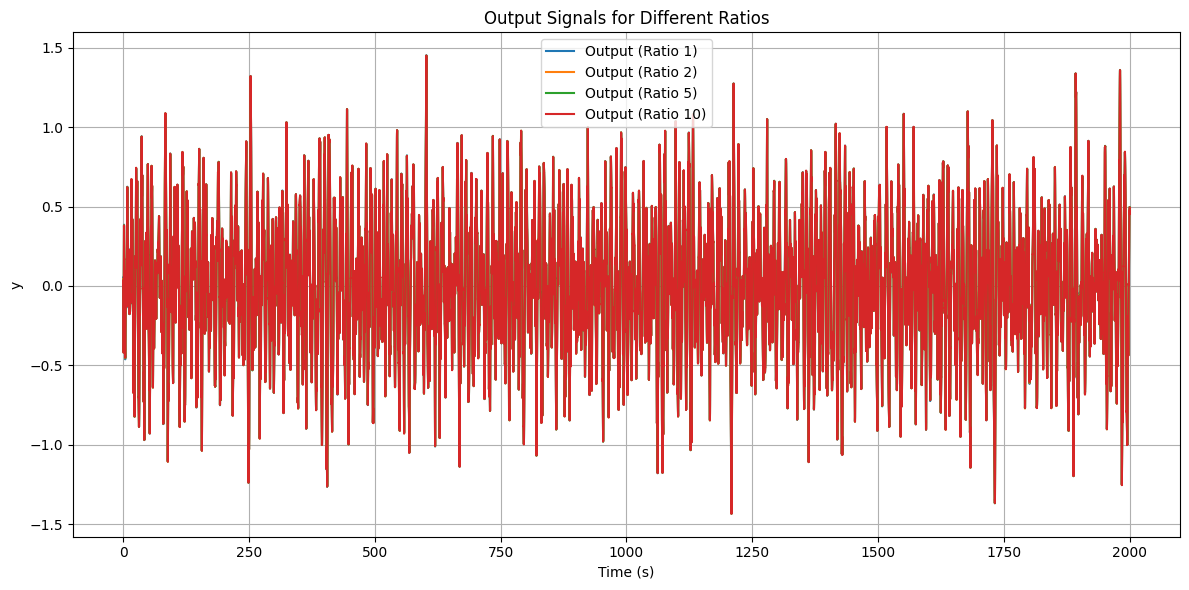

In [6]:
#Generate the test dataset with no noise and different resolutions
noise_std=0.
ratios = [1, 2, 5, 10]  # Refinement ratios
num_segments_test = 20  # Number of segments for the test dataset

# Generate the base input signal (at the finest resolution)
dt_fine_max = t_s / max(ratios)  # Time step for the finest resolution
t_fine_max = np.arange(0, num_segments_test * T_0, dt_fine_max)

# Generate the input signal at the finest resolution
u_fine_full_test_max = np.concatenate([
    multi_sine_with_random_phase_and_frequency_range(
        f_min, f_max, num_freqs, amplitude, t_fine_max[:int(len(t_fine_max) / num_segments_test)]
    )
    for _ in range(num_segments_test)
])[:len(t_fine_max)]  # Ensure it matches the finest time array length

# Initialize lists to store results
t_fine_list = []
datasets_test_fine_list = []

# Loop over each ratio to generate datasets with downsampled time steps
for ratio in ratios:
    dt_fine = t_s / ratio
    t_fine = np.arange(0, num_segments_test * T_0, dt_fine)  # Time array for the current ratio

    # Downsample the input signal to match the current resolution
    indices = np.round(np.linspace(0, len(t_fine_max) - 1, len(t_fine))).astype(int)
    u_fine_full_test = u_fine_full_test_max[indices]

    # Create the system data object for the test dataset
    exp_fine_test = deepSI.System_data(u=u_fine_full_test, dt=dt_fine)

    # Generate the dataset with no noise
    dataset_fine_test = sys2.apply_experiment(exp_fine_test)

    # Reshape inputs and outputs to match nu and ny
    dataset_fine_test.u = dataset_fine_test.u.reshape(-1, nu)
    dataset_fine_test.y = dataset_fine_test.y.reshape(-1, ny)

    # Store t_fine and dataset_fine_test
    t_fine_list.append(t_fine)
    datasets_test_fine_list.append(dataset_fine_test)


# Plot the test datasets for different ratios in one figure
plt.figure(figsize=(12, 6))

# Plot input signals
for i, (t_fine, dataset_fine) in enumerate(zip(t_fine_list, datasets_test_fine_list)):
    plt.plot(t_fine, dataset_fine.u, label=f'Input (Ratio {ratios[i]})')

plt.title('Input Signals for Different Ratios')
plt.xlabel('Time (s)')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Plot output signals
for i, (t_fine, dataset_fine) in enumerate(zip(t_fine_list, datasets_test_fine_list)):
    plt.plot(t_fine, dataset_fine.y, label=f'Output (Ratio {ratios[i]})')

plt.title('Output Signals for Different Ratios')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
#Neural networks: definition of J(x), R(x), H(x)
#choose boolean for constant/state_dependant matrices: constant+boolean*state_dependant

net_kwargs = {'n_nodes_per_layer': 8, 'n_hidden_layers': 1}
net_kwargs_G = {'n_nodes_per_layer': 8, 'n_hidden_layers': 1}
net_kwargs_H = {'n_nodes_per_layer': 16, 'n_hidden_layers': 2}


class Matrix_net(nn.Module):
    # A(x) 
    # A = (Nbatch, n, ncols) if ncols is not given (Nbatch, n, ncols)
    # x = (Nbatch, nx)
    ## Normalized matrix by factor 1/sqrt(ncols) if norm='auto' else *norm will be done
    ## net is called as net(n_in=nx, n_out=n*ncols,**net_kwargs)
    def __init__(self, nx, n, ncols=None, net=feed_forward_nn, net_kwargs={}, norm='auto'):
        super().__init__()
        self.nx = nx
        self.n = n
        self.ncols = ncols if ncols is not None else n
        self.net = net(n_in=nx, n_out=n*self.ncols, **net_kwargs)
        if norm == 'auto':
            self.norm = 1/self.ncols**0.5 if self.ncols>0 else 1
        else:
            self.norm = norm
    
    def forward(self, x):
        return self.net(x).view(x.shape[0], self.n, self.ncols)*self.norm
    
    
class Matrix_res_net(nn.Module):
    # A(x) 
    # A = (Nbatch, n, ncols) if ncols is not given (Nbatch, n, ncols)
    # x = (Nbatch, nx)
    ## Normalized matrix by factor 1/sqrt(ncols) if norm='auto' else *norm will be done
    ## net is called as net(n_in=nx, n_out=n*ncols,**net_kwargs)
    def __init__(self, nx, n, ncols=None, net=simple_res_net, net_kwargs={}, norm='auto'):
        super().__init__()
        self.nx = nx
        self.n = n
        self.ncols = ncols if ncols is not None else n
        self.net = net(n_in=nx, n_out=n*self.ncols, **net_kwargs)
        if norm == 'auto':
            self.norm = 1/self.ncols**0.5 if self.ncols>0 else 1
        else:
            self.norm = norm
    
    def forward(self, x):
        return self.net(x).view(x.shape[0], self.n, self.ncols)*self.norm
    
    

class Sym_pos_semidef_matrix_net(nn.Module):
    def __init__(self, nx, n, net=feed_forward_nn, net_kwargs={}, norm='auto', mode='combined'):
        super().__init__()
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.mat_net = Matrix_net(nx, n, net=net, net_kwargs=net_kwargs, norm=norm)
        self.mode = mode  # Mode: 'nonlinear', 'constant', 'combined'
        self.R_param = nn.Parameter(torch.randn(n, n))  # Learnable parameter

    def forward(self, x):
        A = self.mat_net(x)
        
        # Compute nonlinear part if mode is 'nonlinear' or 'combined'
        R_nn = torch.einsum('bik,bjk->bij', A, A) if self.mode in ['nonlinear', 'combined'] else torch.zeros_like(A)
        
        # Compute constant part if mode is 'constant' or 'combined'
        R_param = torch.mm(self.R_param, self.R_param.t()) if self.mode in ['constant', 'combined'] else torch.zeros_like(self.R_param)
        
        # Combine R_param and R_nn based on mode
        R = R_param + R_nn
        
        return R


class Skew_sym_matrix_net(nn.Module):
    def __init__(self, nx, n, net=feed_forward_nn, net_kwargs={}, norm='auto', mode='combined'):
        super().__init__()
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.mat_net = Matrix_net(nx, n, net=net, net_kwargs=net_kwargs, norm=norm)
        self.mode = mode  # Mode: 'nonlinear', 'constant', 'combined'
        self.J_param = nn.Parameter(torch.randn(n, n))  # Learnable parameter

    def forward(self, x):
        A = self.mat_net(x)
        
        # Compute nonlinear part if mode is 'nonlinear' or 'combined'
        J_nn = A - A.permute(0, 2, 1) if self.mode in ['nonlinear', 'combined'] else torch.zeros_like(A)
        
        # Compute constant part if mode is 'constant' or 'combined'
        J_param_skew = self.J_param - self.J_param.t() if self.mode in ['constant', 'combined'] else torch.zeros_like(self.J_param)
        
        # Combine J_param and J_nn based on mode
        J = J_param_skew + J_nn
        
        return J

    
# Hamiltonian with lower bound
class Lower_bounded_nets(nn.Module):
    def __init__(self, n_in, n_out, lower_bound=0, net=feed_forward_nn, net_kwargs={}):
        super(Lower_bounded_nets, self).__init__()
        self.net = net(n_in, n_out, **net_kwargs)
        self.lower_bound = lower_bound
        
    def forward(self, x):
        y = self.net(x)
        # elu[y - (lower_bound + 1)] + (lower_bound + 1)
        b = self.lower_bound + 1
        return torch.nn.functional.elu(y - b) + b

# Hamiltonian with quadratic node
class HamiltonianMatrixNet(nn.Module):
    def __init__(self, nx, n, net=feed_forward_nn, net_kwargs={}, norm='auto'):
        super(HamiltonianMatrixNet, self).__init__()
        self.boolean = True  # Initially set to False

        # Set up normalization factor
        if norm == 'auto':
            norm = 1 / ((2 + n) * n) ** 0.25 if n > 0 else 1
        self.norm = norm

        # Learnable symmetric positive semi-definite matrix
        self.H_param = nn.Parameter(torch.randn(n, n))

        # Feed-forward neural network
        self.feedforward_nn = net(nx, 1, **net_kwargs)  # Output a single scalar value

    def forward(self, x):
        # Ensure H_param is symmetric and positive semi-definite
        H_param = torch.mm(self.H_param, self.H_param.t())  # H_param * H_param^T ensures positive semi-definiteness
        
        # Compute the quadratic term: 0.5 * norm * x^T H_param x
        quadratic_term = 0.5 * self.norm * torch.einsum('bi,ij,bj->b', x, H_param, x)
        
        # Apply the feed-forward network
        nn_output = self.feedforward_nn(x).squeeze(-1)  # Feed-forward NN produces scalar output per batch
        
        # Combine terms based on the boolean flag
        if self.boolean:
            H = quadratic_term + nn_output
        else:
            H = quadratic_term  # H is a scalar by construction

        return H.unsqueeze(-1)  # Return H as (batch_size, 1)

In [8]:
#Neural networks: definition of final input-state-output port-Hamiltonian NN + encoder
#integrator
def integrate_multi_step_RK4(deriv, dt, x, n_steps=1): #u constant on segment, zero-order hold
    #put here a for loop
    n = n_steps    
    for _ in range(n):
        k1 = dt/n*deriv(x) #t=0
        k2 = dt/n*deriv(x+k1/2) #t=dt/2
        k3 = dt/n*deriv(x+k2/2) #t=dt/2
        k4 = dt/n*deriv(x+k3) #t=dt
        x = x + (k1 + 2*k2 + 2*k3 + k4)/6
    return x

def integrate_multi_step_RK45(deriv, dt, x, n_steps=1): # u constant on segment, zero-order hold
    for _ in range(n_steps):
        k1 = dt * deriv(x)
        k2 = dt * deriv(x + k1 / 4)
        k3 = dt * deriv(x + 3 * k1 / 32 + 9 * k2 / 32)
        k4 = dt * deriv(x + 1932 * k1 / 2197 - 7200 * k2 / 2197 + 7296 * k3 / 2197)
        k5 = dt * deriv(x + 439 * k1 / 216 - 8 * k2 + 3680 * k3 / 513 - 845 * k4 / 4104)
        k6 = dt * deriv(x - 8 * k1 / 27 + 2 * k2 - 3544 * k3 / 2565 + 1859 * k4 / 4104 - 11 * k5 / 40)
        
        x = x + (16 * k1 / 135 + 6656 * k3 / 12825 + 28561 * k4 / 56430 - 9 * k5 / 50 + 2 * k6 / 55)
    return x

def integrate_multi_step_Euler(deriv, dt, x, n_steps=1):  # u constant on segment, zero-order hold
    n = n_steps
    for _ in range(n):
        k1 = dt/n * deriv(x)  # Euler only has a single step, so it's a simple derivative evaluation
        x = x + k1  # Update x by adding the change (slope * step size)
    return x


class SS_encoder_general_hf_deriv(SS_encoder_general_hf):
    @property
    def dt(self):
        return self._dt 
    @dt.setter
    def dt(self,dt):
        self._dt = dt
        self.hfn.dt = dt
        
    def __init__(self, nx=nx, na=na, nb=nb, feedthrough=False, \
                 hf_net=hf_net_default, hf_net_kwargs={}, \
                 e_net=default_encoder_net, e_net_kwargs={}, na_right=0, nb_right=0):

        super(SS_encoder_general_hf_deriv, self).__init__(nx=nx, nb=nb, na=na, na_right=na_right, nb_right=nb_right)
        
        self.e_net = e_net
        self.e_net_kwargs = e_net_kwargs
        self.hf_net = hf_net
        self.hf_net_kwargs = hf_net_kwargs
        self.feedthrough = feedthrough

    def init_nets(self, nu, ny): # a bit weird
        na_right = self.na_right if hasattr(self, 'na_right') else 0
        nb_right = self.nb_right if hasattr(self, 'nb_right') else 0
        self.encoder = self.e_net(nb=self.nb+nb_right, nu=nu, na=self.na+na_right, ny=ny, nx=self.nx, **self.e_net_kwargs)
        self.hfn = self.hf_net(nx=self.nx, nu=nu, ny=ny, **self.hf_net_kwargs)

    def loss(self, uhist, yhist, ufuture, yfuture, **Loss_kwargs):
        x = self.encoder(uhist, yhist) #initialize Nbatch number of states
        errors = []
        for y, u in zip(torch.transpose(yfuture, 0, 1), torch.transpose(ufuture, 0, 1)): #iterate over time
            yhat, x = self.hfn(x, u)
            errors.append(nn.functional.mse_loss(y, yhat)) #calculate error after taking n-steps
        return torch.mean(torch.stack(errors))

    def measure_act_multi(self, actions):
        actions = torch.tensor(np.array(actions), dtype=torch.float32) #(N,...)
        with torch.no_grad():
            y_predict, self.state = self.hfn(self.state, actions)
        return y_predict.numpy()
    

class hf_net_pHNN(nn.Module):
    def __init__(self, nx, nu, ny, feedthrough=False,\
                 Hnet=Lower_bounded_nets, Hnet_kwargs={}, \
                 Jnet=Skew_sym_matrix_net, Jnet_kwargs={}, 
                 Rnet=Sym_pos_semidef_matrix_net, Rnet_kwargs={},
                 Gnet=Matrix_res_net, Gnet_kwargs={}, \
                 integrator=integrate_multi_step_RK4, integrator_kwargs={}, dt=None):
        super(hf_net_pHNN, self).__init__()
        assert nu != None
        assert ny != None
        assert nu==ny
        self.nx = nx
        self.nu = nu
        self.ny = ny
        self.H = Hnet(nx,n_out=1,**Hnet_kwargs)
        self.J = Jnet(nx, n=nx,  mode='nonlinear',**Jnet_kwargs)
        self.R = Rnet(nx, n=nx,  mode='nonlinear',**Rnet_kwargs)
        self.G = Gnet(nx=nx, n=nx, ncols=nu, **Gnet_kwargs) # shape: (Nb, nx, nu)
        self.feedthrough = feedthrough
        self.integrator = integrator
        self.integrator_kwargs = integrator_kwargs
        self.dt = dt
        
    def get_matricies(self, x):
        with torch.enable_grad():
            if x.requires_grad == False:
                x.requires_grad = True
            
            H = self.H(x)[:, 0]
            Hsum = H.sum()
            dHdx = torch.autograd.grad(Hsum, x, create_graph=True)[0]

        J_x = self.J(x)
        R_x = self.R(x)
        G_x = self.G(x)
        return J_x, R_x, G_x, dHdx, H
    
    
    def forward(self, x, u):
        J_x, R_x, G_x, dHdx, H = self.get_matricies(x)
        y_hat = torch.einsum('bij,bi->bj', G_x, dHdx) #bij,bi->bj  = A^T @ dHdx
        
        def f(xnow):
            J_x, R_x, G_x, dHdx, H = self.get_matricies(xnow)
            Gu = torch.einsum('bij,bj->bi',G_x, u.view(u.shape[0], -1)) # G_x (Nb, nx, nu) times u (Nb, nu) = (Nb, nx)
            return torch.einsum('bij,bj->bi', J_x - R_x, dHdx) + Gu
        
        x_next = self.integrator(f, self.dt, x, **self.integrator_kwargs)
        
        # Assuming ny is the output dimension of hn
        if self.feedthrough:
            y_hat = torch.cat([y_hat, u], dim=1)

        return y_hat, x_next

In [ ]:
model = SS_encoder_general_hf_deriv(nx=nx, na=na, nb=nb, hf_net=hf_net_pHNN)
model.fit(dataset_train, dataset_val,epochs=4000,batch_size=256,loss_kwargs=dict(nf=nf)) 
    
    


Initilizing the model and optimizer
Size of the training array =  66.4 MB
N_training_samples = 19781, batch_size = 256, N_batch_updates_per_epoch = 77
Initial Validation sim-NRMS= 1.0025306275899164


  0%|          | 0/4000 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.44485009136369763
Epoch    1, sqrt loss  0.6874, Val sim-NRMS 0.4449, Time Loss: 88.0%, data: 0.0%, val: 12.0%,  9.3 sec/batch
########## New lowest validation loss achieved ########### sim-NRMS = 0.37384302463783775
Epoch    2, sqrt loss  0.3172, Val sim-NRMS 0.3738, Time Loss: 88.2%, data: 0.0%, val: 11.8%,  9.4 sec/batch


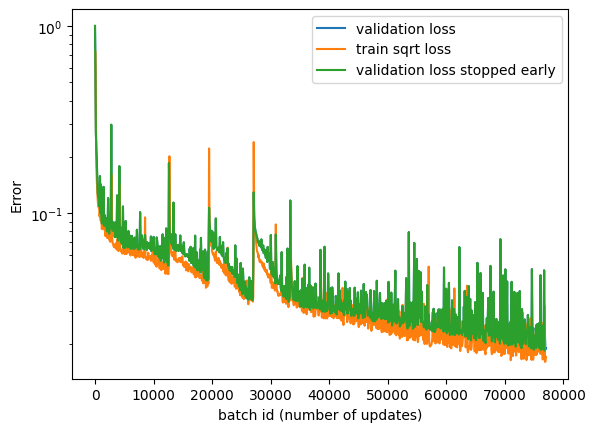

In [19]:
model.checkpoint_load_system('_last')

plt.semilogy(model.batch_id,model.Loss_val,label='validation loss') 

plt.semilogy(model.batch_id,model.Loss_train**0.5,label='train sqrt loss')
plt.xlabel('batch id (number of updates)')
plt.ylabel('Error')

model.checkpoint_load_system('_best')
plt.semilogy(model.batch_id,model.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()

In [15]:
model =  deepSI.load_system('N20000_nonlinear_RK4_T200')

In [16]:
# Perform simulation for each dataset
train_sim = model.apply_experiment(dataset_train)
val_sim = model.apply_experiment(dataset_val)
test_sim_fine_sys_list = []

for dataset_fine_test in datasets_test_fine_list:
    # Apply the model to simulate the system response
    test_sim_fine_sys = model.apply_experiment(dataset_fine_test)
    test_sim_fine_sys_list.append(test_sim_fine_sys)

# Print a summary to confirm the simulations are stored
print(f"Simulations completed for {len(ratios)} ratios.")


Simulations completed for 4 ratios.


In [17]:
# Calculate NRMS and RMS for train and validation datasets

def calculate_metrics_by_segments_fixed_T0(simulated, original, T_0, dt):
    """
    Calculate NRMS and RMS for each segment of fixed duration T_0.
    """
    segment_length = int(T_0 / dt)  # Number of indices per segment for duration T_0
    num_segments = len(original.u) // segment_length  # Total number of full segments
    nrms_values = []
    rms_values = []

    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = start_idx + segment_length

        # Slice the input and output data for the segment
        sim_segment = deepSI.System_data(
            u=simulated.u[start_idx:end_idx],
            y=simulated.y[start_idx:end_idx],
            dt=dt
        )
        orig_segment = deepSI.System_data(
            u=original.u[start_idx:end_idx],
            y=original.y[start_idx:end_idx],
            dt=dt
        )

        # Calculate NRMS and RMS for the segment
        nrms_values.append(sim_segment.NRMS(orig_segment))
        rms_values.append(sim_segment.RMS(orig_segment))

    # Calculate mean and standard deviation
    nrms_mean = np.mean(nrms_values)
    nrms_std = np.std(nrms_values)
    rms_mean = np.mean(rms_values)
    rms_std = np.std(rms_values)

    return nrms_values, rms_values, nrms_mean, nrms_std, rms_mean, rms_std


# Calculate metrics for training dataset
train_nrms, train_rms, train_nrms_mean, train_nrms_std, train_rms_mean, train_rms_std = calculate_metrics_by_segments_fixed_T0(
    train_sim, dataset_train, T_0=100, dt=0.1
)

# Calculate metrics for validation dataset
val_nrms, val_rms, val_nrms_mean, val_nrms_std, val_rms_mean, val_rms_std = calculate_metrics_by_segments_fixed_T0(
    val_sim, dataset_val, T_0=100, dt=0.1
)

# Reporting the results
print(f"Train Dataset Metrics:")
print(f"  NRMS (mean): {train_nrms_mean:.5f}, NRMS (std): {train_nrms_std:.5f}")
print(f"  RMS  (mean): {train_rms_mean:.7f}, RMS  (std): {train_rms_std:.7f}\n")

print(f"Validation Dataset Metrics:")
print(f"  NRMS (mean): {val_nrms_mean:.5f}, NRMS (std): {val_nrms_std:.5f}")
print(f"  RMS  (mean): {val_rms_mean:.7f}, RMS  (std): {val_rms_std:.7f}\n")


Train Dataset Metrics:
  NRMS (mean): 0.02018, NRMS (std): 0.01000
  RMS  (mean): 0.0085435, RMS  (std): 0.0046079

Validation Dataset Metrics:
  NRMS (mean): 0.02422, NRMS (std): 0.01098
  RMS  (mean): 0.0102440, RMS  (std): 0.0047390



In [18]:
# Calculate NRMS and RMS for test dataset with different resolutions
def calculate_metrics_by_segments_test_ratios(simulated_list, original_list, T_0, ratios):
    """
    Calculate NRMS and RMS for each segment of fixed duration T_0 for multiple ratios.
    """
    results = {}

    for ratio, simulated, original in zip(ratios, simulated_list, original_list):
        dt_fine = t_s / ratio  # Time step for the current ratio
        segment_length = int(T_0 / dt_fine)  # Number of indices per segment for duration T_0
        num_segments = len(original.u) // segment_length  # Total number of full segments
        nrms_values = []
        rms_values = []

        for i in range(num_segments):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length

            # Slice the input and output data for the segment
            sim_segment = deepSI.System_data(
                u=simulated.u[start_idx:end_idx],
                y=simulated.y[start_idx:end_idx],
                dt=dt_fine
            )
            orig_segment = deepSI.System_data(
                u=original.u[start_idx:end_idx],
                y=original.y[start_idx:end_idx],
                dt=dt_fine
            )

            # Calculate NRMS and RMS for the segment
            nrms_values.append(sim_segment.NRMS(orig_segment))
            rms_values.append(sim_segment.RMS(orig_segment))

        # Calculate mean and standard deviation
        nrms_mean = np.mean(nrms_values)
        nrms_std = np.std(nrms_values)
        rms_mean = np.mean(rms_values)
        rms_std = np.std(rms_values)

        # Store results for this ratio
        results[ratio] = {
            "nrms_values": nrms_values,
            "rms_values": rms_values,
            "nrms_mean": nrms_mean,
            "nrms_std": nrms_std,
            "rms_mean": rms_mean,
            "rms_std": rms_std,
        }

    return results


# Calculate metrics for test dataset with different ratios
test_results = calculate_metrics_by_segments_test_ratios(
    test_sim_fine_sys_list,  # Simulated test datasets
    datasets_test_fine_list,  # Original test datasets
    T_0=100,  # Segment duration
    ratios=ratios  # Refinement ratios
)

# Reporting the results
for ratio, result in test_results.items():
    print(f"Test Dataset Metrics for Ratio {ratio}:")
    print(f"  NRMS (mean): {result['nrms_mean']:.5f}, NRMS (std): {result['nrms_std']:.5f}")
    print(f"  RMS  (mean): {result['rms_mean']:.7f}, RMS  (std): {result['rms_std']:.7f}\n")


Test Dataset Metrics for Ratio 1:
  NRMS (mean): 0.01900, NRMS (std): 0.00451
  RMS  (mean): 0.0079333, RMS  (std): 0.0017439

Test Dataset Metrics for Ratio 2:
  NRMS (mean): 0.03172, NRMS (std): 0.05445
  RMS  (mean): 0.0133767, RMS  (std): 0.0233459

Test Dataset Metrics for Ratio 5:
  NRMS (mean): 0.02921, NRMS (std): 0.04350
  RMS  (mean): 0.0123026, RMS  (std): 0.0186552

Test Dataset Metrics for Ratio 10:
  NRMS (mean): 0.02172, NRMS (std): 0.01156
  RMS  (mean): 0.0090956, RMS  (std): 0.0049294



In [32]:
# Calculate NRMS and RMS for test dataset with different resolutions
def calculate_metrics_by_segments_test_ratios(simulated_list, original_list, T_0, ratios, skip_start_time=30):
    """
    Calculate NRMS and RMS for each segment of fixed duration T_0 for multiple ratios,
    skipping the first `skip_start_time` seconds only in the first segment.
    """
    results = {}

    for ratio, simulated, original in zip(ratios, simulated_list, original_list):
        dt_fine = t_s / ratio  # Time step for the current ratio
        segment_length = int(T_0 / dt_fine)  # Number of indices per segment for duration T_0
        num_segments = len(original.u) // segment_length  # Total number of full segments
        nrms_values = []
        rms_values = []

        for i in range(num_segments):
            if i == 0:
                # First segment: Skip the first `skip_start_time` seconds
                skip_idx = int(skip_start_time / dt_fine)
                start_idx = 0 + skip_idx
                end_idx = segment_length
            else:
                # Subsequent segments: Process the full segment
                start_idx = i * segment_length
                end_idx = start_idx + segment_length

            # Ensure indices are within the valid range
            if end_idx > len(original.u):
                break

            # Slice the input and output data for the segment
            sim_segment = deepSI.System_data(
                u=simulated.u[start_idx:end_idx],
                y=simulated.y[start_idx:end_idx],
                dt=dt_fine
            )
            orig_segment = deepSI.System_data(
                u=original.u[start_idx:end_idx],
                y=original.y[start_idx:end_idx],
                dt=dt_fine
            )

            # Calculate NRMS and RMS for the segment
            nrms_values.append(sim_segment.NRMS(orig_segment))
            rms_values.append(sim_segment.RMS(orig_segment))

        # Calculate mean and standard deviation
        nrms_mean = np.mean(nrms_values)
        nrms_std = np.std(nrms_values)
        rms_mean = np.mean(rms_values)
        rms_std = np.std(rms_values)

        # Store results for this ratio
        results[ratio] = {
            "nrms_values": nrms_values,
            "rms_values": rms_values,
            "nrms_mean": nrms_mean,
            "nrms_std": nrms_std,
            "rms_mean": rms_mean,
            "rms_std": rms_std,
        }

    return results


# Calculate metrics for test dataset with different ratios
test_results = calculate_metrics_by_segments_test_ratios(
    test_sim_fine_sys_list,  # Simulated test datasets
    datasets_test_fine_list,  # Original test datasets
    T_0=100,  # Segment duration
    ratios=ratios,  # Refinement ratios
    skip_start_time=30  # Time to skip for the first segment
)

# Reporting the results
for ratio, result in test_results.items():
    print(f"Test Dataset Metrics for Ratio {ratio}:")
    print(f"  NRMS (mean): {result['nrms_mean']:.5f}, NRMS (std): {result['nrms_std']:.5f}")
    print(f"  RMS  (mean): {result['rms_mean']:.7f}, RMS  (std): {result['rms_std']:.7f}\n")


Test Dataset Metrics for Ratio 1:
  NRMS (mean): 0.01882, NRMS (std): 0.00474
  RMS  (mean): 0.0078698, RMS  (std): 0.0018208

Test Dataset Metrics for Ratio 2:
  NRMS (mean): 0.01918, NRMS (std): 0.00438
  RMS  (mean): 0.0080300, RMS  (std): 0.0016846

Test Dataset Metrics for Ratio 5:
  NRMS (mean): 0.01924, NRMS (std): 0.00438
  RMS  (mean): 0.0080595, RMS  (std): 0.0016921

Test Dataset Metrics for Ratio 10:
  NRMS (mean): 0.01887, NRMS (std): 0.00468
  RMS  (mean): 0.0078913, RMS  (std): 0.0017903



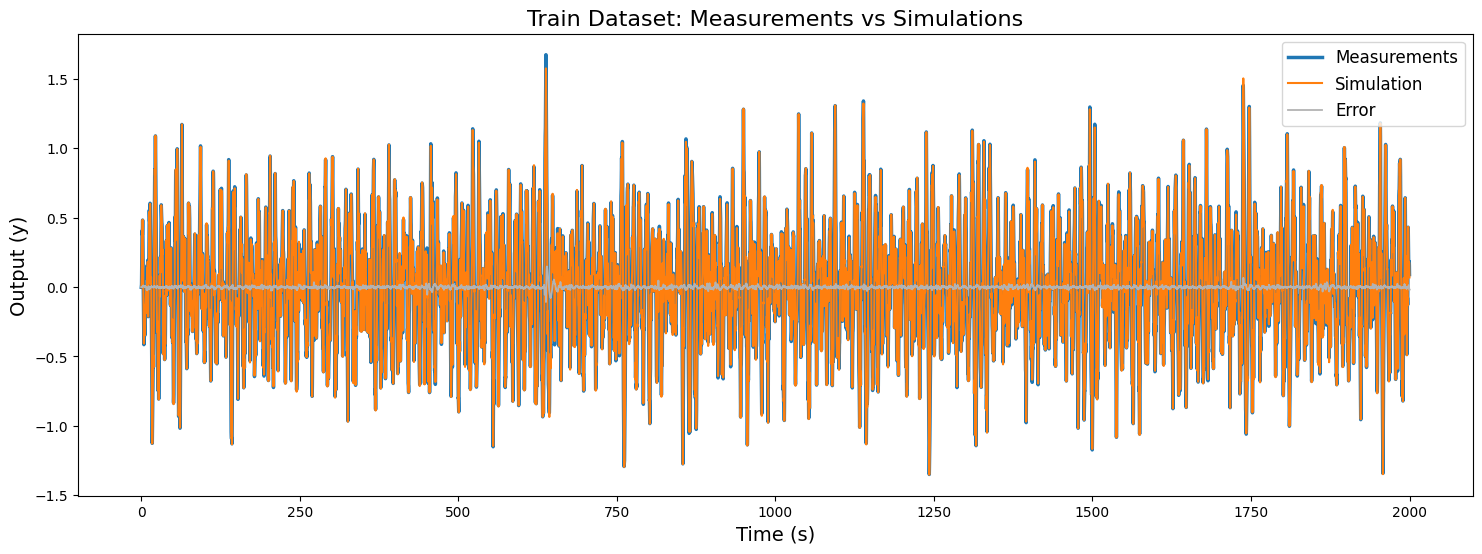

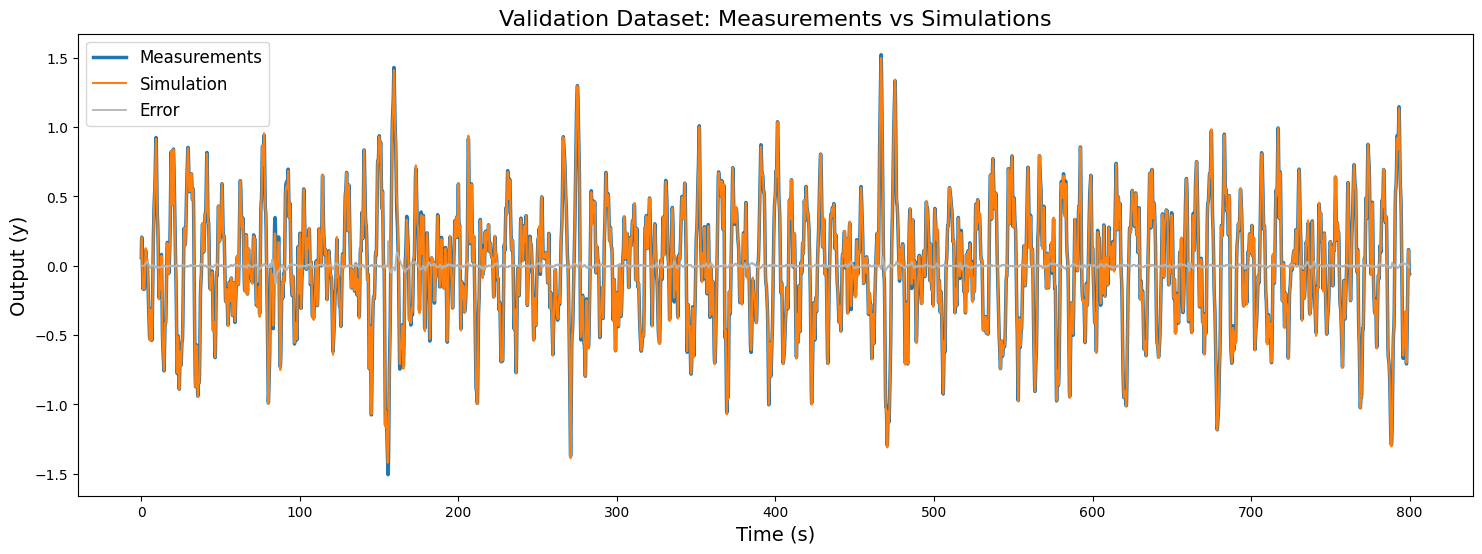

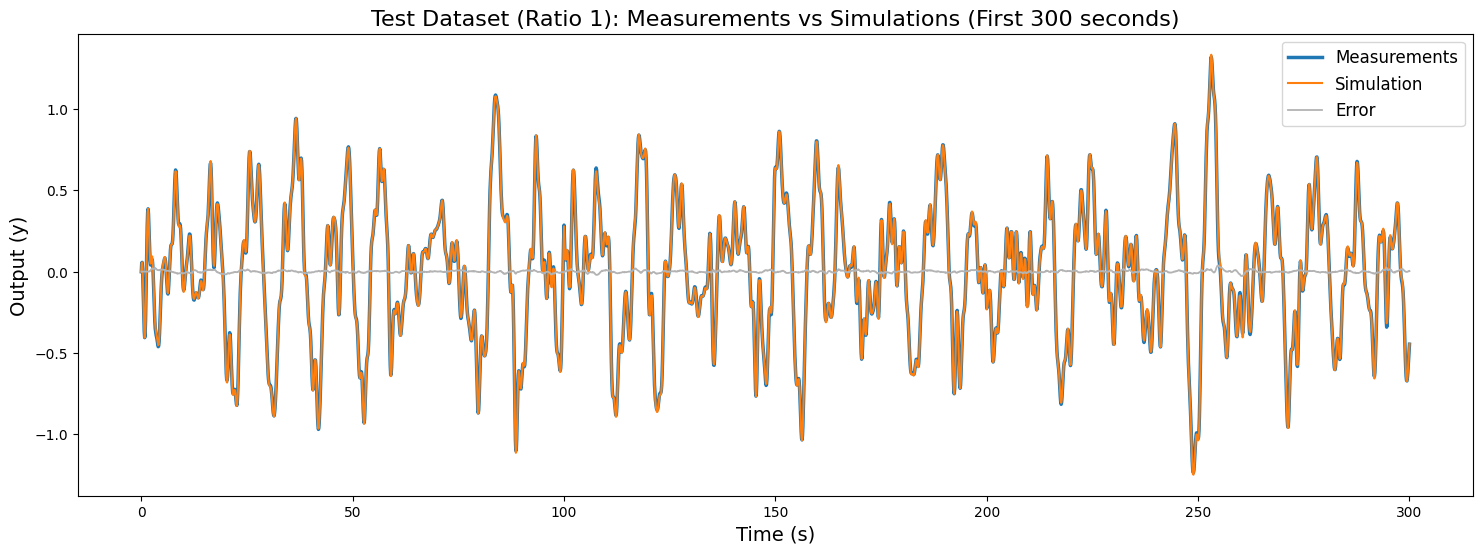

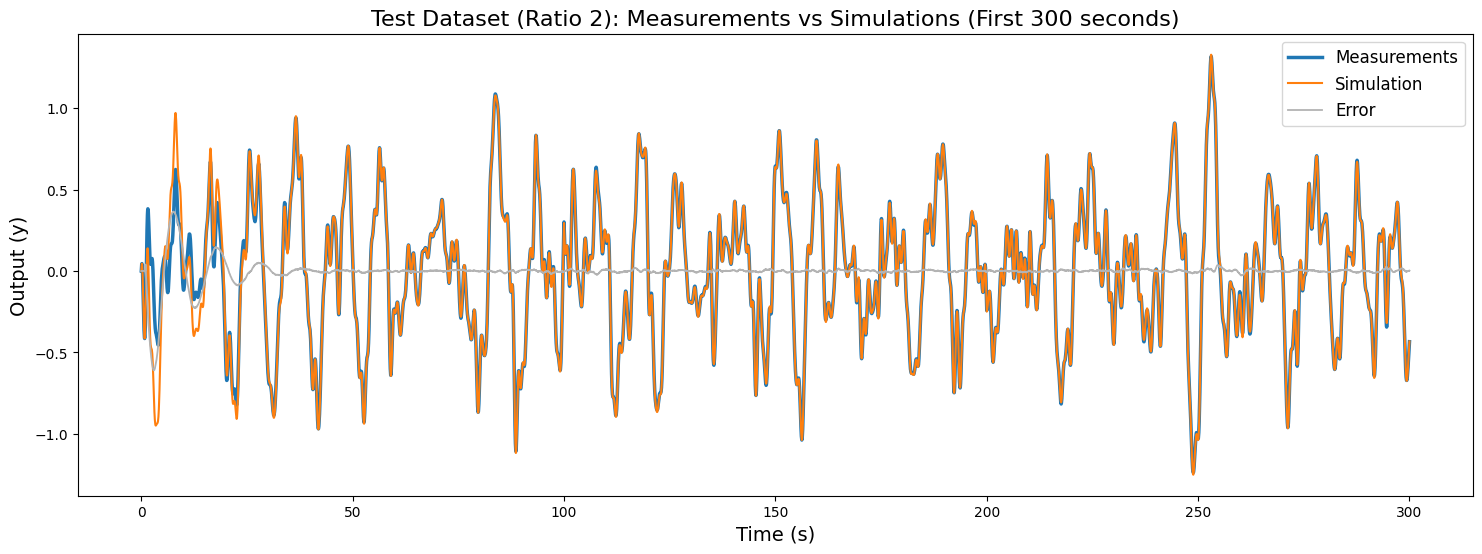

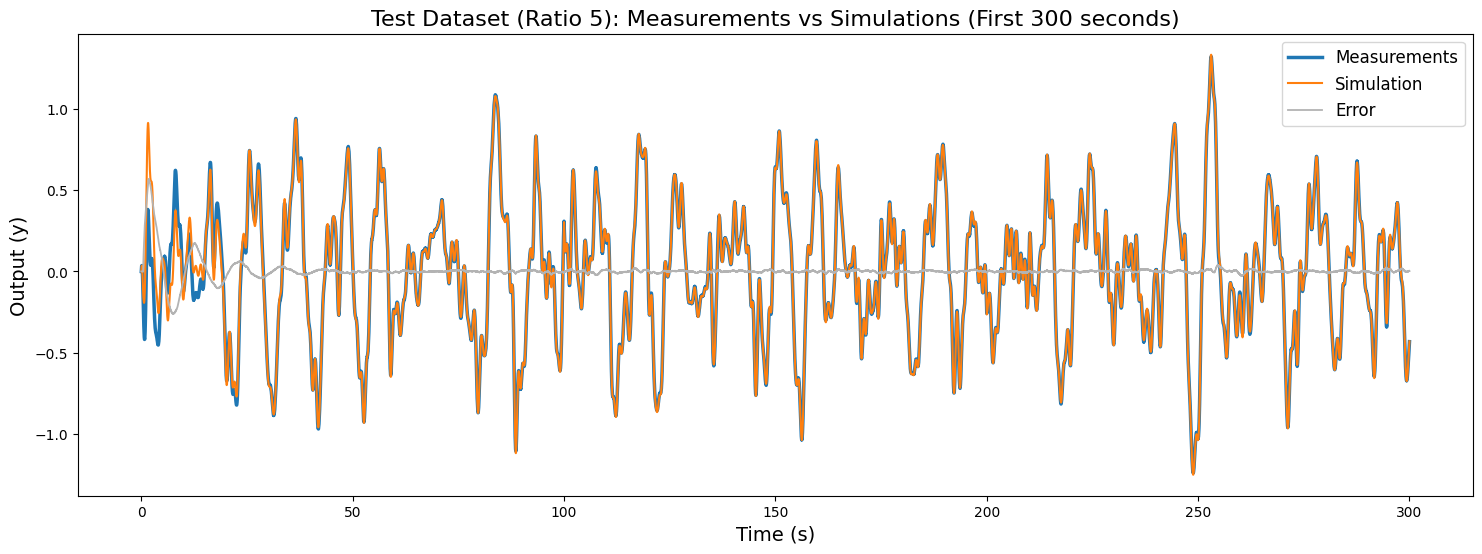

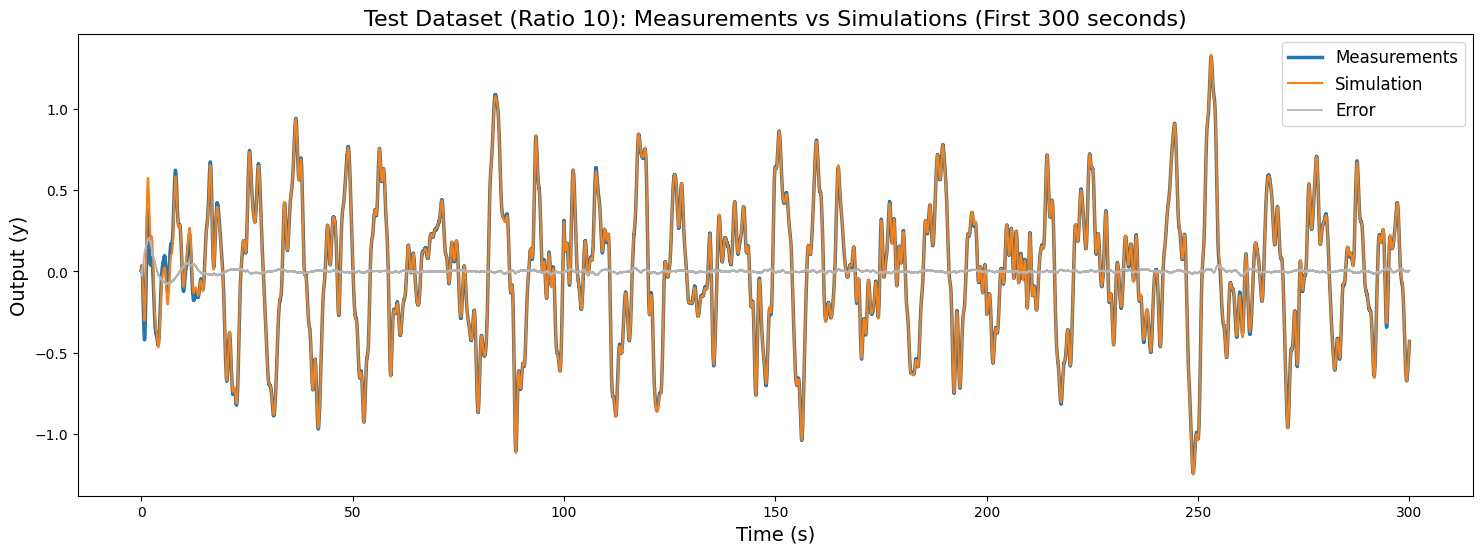

In [25]:
# Define a function to plot results for train, validation, and test datasets
def plot_results_with_error(dataset, simulation, title, filename, time_limit=None):
    """
    Plot measurements, simulation, and error for the provided dataset and save as SVG.
    """
    plt.figure(figsize=(18, 6))
    time_vector = np.arange(0, len(dataset.y) * dataset.dt, dataset.dt)
    
    if time_limit:
        # Limit the data to the specified time limit
        time_idx = np.where(time_vector <= time_limit)[0]
        time_vector = time_vector[time_idx]
        measurements = dataset.y[time_idx]
        simulation_results = simulation.y[time_idx]
    else:
        measurements = dataset.y
        simulation_results = simulation.y

    # Plot measurements and simulation
    plt.plot(time_vector, measurements, linewidth=2.5, label="Measurements")
    plt.plot(time_vector, simulation_results, linewidth=1.5, label="Simulation")

    # Calculate error
    error = simulation_results - measurements
    plt.plot(time_vector, error, color=(0.7, 0.7, 0.7), linewidth=1.3, label="Error")

    # Add labels, title, and legend
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Output (y)", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    
    # Save as SVG
    plt.savefig(f"{filename}.svg", format="svg", bbox_inches="tight")
    plt.show()


# Plot for train dataset (whole)
plot_results_with_error(
    dataset_train, train_sim,
    title="Train Dataset: Measurements vs Simulations",
    filename="train_dataset_plot"
)

# Plot for validation dataset (whole)
plot_results_with_error(
    dataset_val, val_sim,
    title="Validation Dataset: Measurements vs Simulations",
    filename="val_dataset_plot"
)

# Plot for test datasets with different resolutions (first 300 seconds)
time_limit = 300
for i, ratio in enumerate(ratios):
    dataset_fine_test = datasets_test_fine_list[i]
    test_sim_fine_sys = test_sim_fine_sys_list[i]
    plot_results_with_error(
        dataset_fine_test, test_sim_fine_sys,
        title=f"Test Dataset (Ratio {ratio}): Measurements vs Simulations (First {time_limit} seconds)",
        filename=f"test_dataset_ratio_{ratio}_plot",
        time_limit=time_limit
    )


In [36]:
# Change the integrator and its settings
model.hfn.integrator = integrate_multi_step_Euler
model.hfn.integrator_kwargs = {'n_steps': 1}

# Re-simulate the system with the updated integrator
test_sim_fine_sys_list = []

for dataset_fine_test in datasets_test_fine_list:
    # Apply the model to simulate the system response
    test_sim_fine_sys = model.apply_experiment(dataset_fine_test)
    test_sim_fine_sys_list.append(test_sim_fine_sys)

# Confirm that simulations are complete
print(f"Simulations completed for {len(ratios)} ratios.")


Simulations completed for 4 ratios.


In [37]:
# Calculate NRMS and RMS for test dataset with different resolutions
def calculate_metrics_by_segments_test_ratios(simulated_list, original_list, T_0, ratios, skip_start_time=30):
    """
    Calculate NRMS and RMS for each segment of fixed duration T_0 for multiple ratios,
    skipping the first `skip_start_time` seconds only in the first segment.
    """
    results = {}

    for ratio, simulated, original in zip(ratios, simulated_list, original_list):
        dt_fine = t_s / ratio  # Time step for the current ratio
        segment_length = int(T_0 / dt_fine)  # Number of indices per segment for duration T_0
        num_segments = len(original.u) // segment_length  # Total number of full segments
        nrms_values = []
        rms_values = []

        for i in range(num_segments):
            if i == 0:
                # First segment: Skip the first `skip_start_time` seconds
                skip_idx = int(skip_start_time / dt_fine)
                start_idx = 0 + skip_idx
                end_idx = segment_length
            else:
                # Subsequent segments: Process the full segment
                start_idx = i * segment_length
                end_idx = start_idx + segment_length

            # Ensure indices are within the valid range
            if end_idx > len(original.u):
                break

            # Slice the input and output data for the segment
            sim_segment = deepSI.System_data(
                u=simulated.u[start_idx:end_idx],
                y=simulated.y[start_idx:end_idx],
                dt=dt_fine
            )
            orig_segment = deepSI.System_data(
                u=original.u[start_idx:end_idx],
                y=original.y[start_idx:end_idx],
                dt=dt_fine
            )

            # Calculate NRMS and RMS for the segment
            nrms_values.append(sim_segment.NRMS(orig_segment))
            rms_values.append(sim_segment.RMS(orig_segment))

        # Calculate mean and standard deviation
        nrms_mean = np.mean(nrms_values)
        nrms_std = np.std(nrms_values)
        rms_mean = np.mean(rms_values)
        rms_std = np.std(rms_values)

        # Store results for this ratio
        results[ratio] = {
            "nrms_values": nrms_values,
            "rms_values": rms_values,
            "nrms_mean": nrms_mean,
            "nrms_std": nrms_std,
            "rms_mean": rms_mean,
            "rms_std": rms_std,
        }

    return results


# Calculate metrics for test dataset with different ratios
test_results = calculate_metrics_by_segments_test_ratios(
    test_sim_fine_sys_list,  # Simulated test datasets
    datasets_test_fine_list,  # Original test datasets
    T_0=100,  # Segment duration
    ratios=ratios,  # Refinement ratios
    skip_start_time=30  # Time to skip for the first segment
)

# Reporting the results
for ratio, result in test_results.items():
    print(f"Test Dataset Metrics for Ratio {ratio}:")
    print(f"  NRMS (mean): {result['nrms_mean']:.5f}, NRMS (std): {result['nrms_std']:.5f}")
    print(f"  RMS  (mean): {result['rms_mean']:.7f}, RMS  (std): {result['rms_std']:.7f}\n")


Test Dataset Metrics for Ratio 1:
  NRMS (mean): 0.82256, NRMS (std): 0.39847
  RMS  (mean): 0.3466350, RMS  (std): 0.1692707

Test Dataset Metrics for Ratio 2:
  NRMS (mean): 0.05482, NRMS (std): 0.00737
  RMS  (mean): 0.0230264, RMS  (std): 0.0030015

Test Dataset Metrics for Ratio 5:
  NRMS (mean): 0.02922, NRMS (std): 0.00515
  RMS  (mean): 0.0122462, RMS  (std): 0.0019243

Test Dataset Metrics for Ratio 10:
  NRMS (mean): 0.02275, NRMS (std): 0.00511
  RMS  (mean): 0.0095155, RMS  (std): 0.0019274



In [38]:
# Change the integrator and its settings
model.hfn.integrator = integrate_multi_step_RK45
model.hfn.integrator_kwargs = {'n_steps': 1}

# Re-simulate the system with the updated integrator
test_sim_fine_sys_list = []

for dataset_fine_test in datasets_test_fine_list:
    # Apply the model to simulate the system response
    test_sim_fine_sys = model.apply_experiment(dataset_fine_test)
    test_sim_fine_sys_list.append(test_sim_fine_sys)

# Confirm that simulations are complete
print(f"Simulations completed for {len(ratios)} ratios.")

Simulations completed for 4 ratios.


In [39]:
# Calculate NRMS and RMS for test dataset with different resolutions
def calculate_metrics_by_segments_test_ratios(simulated_list, original_list, T_0, ratios, skip_start_time=30):
    """
    Calculate NRMS and RMS for each segment of fixed duration T_0 for multiple ratios,
    skipping the first `skip_start_time` seconds only in the first segment.
    """
    results = {}

    for ratio, simulated, original in zip(ratios, simulated_list, original_list):
        dt_fine = t_s / ratio  # Time step for the current ratio
        segment_length = int(T_0 / dt_fine)  # Number of indices per segment for duration T_0
        num_segments = len(original.u) // segment_length  # Total number of full segments
        nrms_values = []
        rms_values = []

        for i in range(num_segments):
            if i == 0:
                # First segment: Skip the first `skip_start_time` seconds
                skip_idx = int(skip_start_time / dt_fine)
                start_idx = 0 + skip_idx
                end_idx = segment_length
            else:
                # Subsequent segments: Process the full segment
                start_idx = i * segment_length
                end_idx = start_idx + segment_length

            # Ensure indices are within the valid range
            if end_idx > len(original.u):
                break

            # Slice the input and output data for the segment
            sim_segment = deepSI.System_data(
                u=simulated.u[start_idx:end_idx],
                y=simulated.y[start_idx:end_idx],
                dt=dt_fine
            )
            orig_segment = deepSI.System_data(
                u=original.u[start_idx:end_idx],
                y=original.y[start_idx:end_idx],
                dt=dt_fine
            )

            # Calculate NRMS and RMS for the segment
            nrms_values.append(sim_segment.NRMS(orig_segment))
            rms_values.append(sim_segment.RMS(orig_segment))

        # Calculate mean and standard deviation
        nrms_mean = np.mean(nrms_values)
        nrms_std = np.std(nrms_values)
        rms_mean = np.mean(rms_values)
        rms_std = np.std(rms_values)

        # Store results for this ratio
        results[ratio] = {
            "nrms_values": nrms_values,
            "rms_values": rms_values,
            "nrms_mean": nrms_mean,
            "nrms_std": nrms_std,
            "rms_mean": rms_mean,
            "rms_std": rms_std,
        }

    return results


# Calculate metrics for test dataset with different ratios
test_results = calculate_metrics_by_segments_test_ratios(
    test_sim_fine_sys_list,  # Simulated test datasets
    datasets_test_fine_list,  # Original test datasets
    T_0=100,  # Segment duration
    ratios=ratios,  # Refinement ratios
    skip_start_time=30  # Time to skip for the first segment
)

# Reporting the results
for ratio, result in test_results.items():
    print(f"Test Dataset Metrics for Ratio {ratio}:")
    print(f"  NRMS (mean): {result['nrms_mean']:.5f}, NRMS (std): {result['nrms_std']:.5f}")
    print(f"  RMS  (mean): {result['rms_mean']:.7f}, RMS  (std): {result['rms_std']:.7f}\n")

Test Dataset Metrics for Ratio 1:
  NRMS (mean): 0.01882, NRMS (std): 0.00474
  RMS  (mean): 0.0078697, RMS  (std): 0.0018203

Test Dataset Metrics for Ratio 2:
  NRMS (mean): 0.01918, NRMS (std): 0.00438
  RMS  (mean): 0.0080300, RMS  (std): 0.0016846

Test Dataset Metrics for Ratio 5:
  NRMS (mean): 0.01924, NRMS (std): 0.00438
  RMS  (mean): 0.0080595, RMS  (std): 0.0016921

Test Dataset Metrics for Ratio 10:
  NRMS (mean): 0.01887, NRMS (std): 0.00468
  RMS  (mean): 0.0078913, RMS  (std): 0.0017903



In [48]:
# save to file 
model.save_system('N20000_nonlinear_RK4_T200')

# Read trained model
#model =  deepSI.load_system('N20000_nonlinear_RK4_T200')

In [41]:
# Saving the datasets 
import pickle

# Save datasets and simulations to a file
with open("datasets_and_simulations.pkl", "wb") as f:
    pickle.dump({
        "train": {"dataset": dataset_train, "simulation": train_sim},
        "validation": {"dataset": dataset_val, "simulation": val_sim},
        "test": {
            "ratios": ratios,
            "datasets": datasets_test_fine_list,
            "simulations": test_sim_fine_sys_list,
        },
    }, f)

print("Datasets and simulations saved successfully.")


Datasets and simulations saved successfully.


In [ ]:
# Load datasets and simulations from a file
#with open("datasets_and_simulations.pkl", "rb") as f:
    #data = pickle.load(f)

# Extract datasets and simulations
#dataset_train = data["train"]["dataset"]
#train_sim = data["train"]["simulation"]

#dataset_val = data["validation"]["dataset"]
#val_sim = data["validation"]["simulation"]

#ratios = data["test"]["ratios"]
#datasets_test_fine_list = data["test"]["datasets"]
#test_sim_fine_sys_list = data["test"]["simulations"]

#print("Datasets and simulations loaded successfully.")
